<a href="https://colab.research.google.com/github/danb-neo4j/NODES2022_GraphEDA/blob/main/NODES2022_TabularEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NODES 2022: Graph EDA Workshop Demo Notebook
Author: Daniel Bukowski, Neo4j Graph Data Science Customer Success Architect

Workshop Date: November 2, 2022

Notebook Updated: October 31, 2022

# Exercise Scenario
*From the [Kaggle Competition Website](https://www.kaggle.com/competitions/spaceship-titanic)*

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

**To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.**

**Help save them and change history!**

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette("colorblind")
sns.set(rc={'figure.figsize':(11,6)})

import os 
import configparser
from collections import Counter

import missingno as msno

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate

# Custom Functions

In [2]:
def horizontal_countplot(df: pd.DataFrame, 
                         col: str, 
                         title: str,
                         order: list = None) -> None:
  '''Generate a horizontal seaborn catplot of values in a categorical feature

  Args:
    df: dataframe containing the data
    col: categorical column to plot
    title: title of the plot 
  '''

  (
      sns.countplot(data=df, y=col, order=order)
      .set(title=title)
  )

  plt.show()

In [3]:
def plot_transported_pct(df: pd.DataFrame, 
                         col: str, 
                         title: str,
                         figsize: tuple = (10,5),
                         color: str = 'r') -> None:
  '''Generate a horizontal bar chart of transported pct for a category
     using the pandas matplotlib wrapper

  Args:
    df: pandas dataframe containing the data 
    col: column to analyze transported percentage 
    title: title for the plot
    figsize: size of the plot; defaults to (10, 5)
    color: color of the bars; defaults to red

  Returns:
    None; plots a chart of the pct of passengers transported
  '''
  (
    df[[col, 'Transported']]
    .groupby(col)
    .agg('mean')
    .sort_values('Transported')
    .plot(kind='barh',
          figsize=figsize,
          color = color,
          title=title)
  )
  plt.show()

In [4]:
def fill_categorical(df: pd.DataFrame, 
                     col: str, 
                     fill_value: str) -> pd.DataFrame:
  '''Impute missing values in a DataFrame feature by passenger group size

  Args:
    df: dataframe containing the data
    col: categorical column to plot
    fill_value: arbitrary value to fill for solo or other passengers 
  '''
  
  # PASSENGERS TRAVELING ALONE
  # generate a mask of missing values; fill solo travelers with fill_value
  mask = df[col].isna()
  df.loc[mask, col] = np.where(df.loc[mask, 'Group_Size'].eq(1), fill_value, pd.NA)

  # PASSENGERS TRAVELING IN GROUP OF 2+
  # use forward-fill and back-fill to fill with values in same group
  df[col] = df.groupby('Passenger_Group')[col].transform(lambda x: x.ffill())
  df[col] = df.groupby('Passenger_Group')[col].transform(lambda x: x.bfill())

  # OUTLIER CLEANUP
  # final fill using fill_value for edge cases (all passengers in a group missing values)
  df[col].fillna(fill_value, inplace=True)

  return df

In [5]:
def create_desc_df(df: pd.DataFrame, col: str) -> pd.DataFrame:
  '''Create a three-column dataframe describing quantitative variables
     as All, Transported, and, Not Transported
  
  Args:
    df: dataframe containing the data
    col: column to describe
  '''
  df = pd.concat([pd.DataFrame(round(train_df[col].describe(), 0)),
                  pd.DataFrame(round(train_df[train_df['Transported'] == True][col].describe(), 0)),
                  pd.DataFrame(round(train_df[train_df['Transported'] == False][col].describe(), 0))
              ],axis=1)

  df.columns = ['All', 'Transported', 'Not Transported']

  return df

In [6]:
def plot_transported_hist(df: pd.DataFrame, 
                          col: str, 
                          bins: int = 20, 
                          log: bool = False) -> None:
  '''Plot a histogram overlaying transported and non-transported passengers

  Args:
    df: dataframe containing the data
    col: column to plot
    bins: number of histogram bins; default 20
    log: plotting in log scale; default False
  '''
  df[df['Transported']==False][col].plot(kind='hist', 
                                         log=log, 
                                         bins=bins, 
                                         color='blue', 
                                         alpha=0.5,
                                         label='Not Transported')
  df[df['Transported']==True][col].plot(kind='hist', 
                                         log=log, 
                                         bins=bins, 
                                         color='red', 
                                         alpha=0.5,
                                         label='Transported')

  if log == True:
    plt.title(f'{col} by Transported Status -- Log Scale')
  else:
    plt.title(f'{col} by Transported Status')
  plt.legend() 
  plt.show()


# Connect to Colab

In [7]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
os.chdir('drive/MyDrive/Colab Notebooks/NODES_2022_Workshop/')

# Import Data

In [9]:
train_df = pd.read_csv("source_data/spaceshipTitanic_train.csv")
test_df = pd.read_csv("source_data/spaceshipTitanic_test.csv")

print('train dataframe dimensions:', train_df.shape)
print('test dataframe dimensions:', test_df.shape)

train dataframe dimensions: (8693, 14)
test dataframe dimensions: (4277, 13)


In [10]:
# list to iterate through during preprocessing
full_data = [train_df, test_df]

# Data Overview
*The data used in this demonstration is already split into traning and test data sets. We know from prior analysis that these data sets have similar features and missing values. For simplicity, this notebook will focus on the training data knowing that the analysis applies to the test data as well.*

## Feature Descriptions
From the [Kaggle competition website](https://www.kaggle.com/competitions/spaceship-titanic/data): 

* `PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
* `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* `Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* `Destination` - The planet the passenger will be debarking to.
* `Age` - The age of the passenger.
* `VIP` - Whether the passenger has paid for special VIP service during the voyage.
* `RoomService, FoodCourt, ShoppingMall, Spa, VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* `Name` - The first and last names of the passenger.
* `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

## Data Summary 

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [12]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Descriptive Statistics

## Categorical Features

In [13]:
train_df.describe(include='object').round().T

,count,unique,top,freq
PassengerId,8693,8693,0001_01,1
HomePlanet,8492,3,Earth,4602
CryoSleep,8476,2,False,5439
Cabin,8494,6560,G/734/S,8
Destination,8511,3,TRAPPIST-1e,5915
VIP,8490,2,False,8291
Name,8493,8473,Gollux Reedall,2


### Analysis of Categorical Features
* `PassengerId:` All values are unique, so we can likely use this as a unique identifier if necesary. 
* `HomePlanet:` Three unique values with Earth as the most common, comprising slightly more than 50% of values.
* `CryoSleep:` Boolean with False comprising almost 65% of values.
* `Cabin:` Approximately 20% of Cabin values are duplicates, which makes sense given that some passengers share a cabin. The most frequent duplicates occur eight times in the data. 
* `Destination:` Three unique values with TRAPPIST-1e comprising 70% of values.
* `VIP:` Boolean with False comprising 99% of values.
* `Name:` There appear to be a small number of passengers (~20) with duplicate names, so we won't want to use this feature as a unique identifier. 

## Numeric Features

In [14]:
train_df.describe().round().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,29.0,14.0,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,225.0,667.0,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.0,1611.0,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,174.0,605.0,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.0,1137.0,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,305.0,1146.0,0.0,0.0,0.0,46.0,24133.0


### Analysis of Quantative Features
* `Age:` Passenger ages range from 0 to 79 years old with the mean being 29 and the median being 27. The age feature is clearly on a different scale than the spend categories, which could influence downstream modeling efforts.
* `Spend Categories:` All the other quantitative categories (`RoomService, Food Court, ShoppingMall, Spa, and VRDeck`)
  * Median values are zero indicating that at least half of the passengers don't spend while on the ship. 
  * The data also appear to be skewed based upon passengers who spend large amounts in each of the locations.


# Missing Data

In [16]:
# missing entries 
print('Percentage of missing entries per feature:\n')
round(train_df.isna().sum() / train_df.shape[0], 2)

Percentage of missing entries per feature:



PassengerId     0.00
HomePlanet      0.02
CryoSleep       0.02
Cabin           0.02
Destination     0.02
Age             0.02
VIP             0.02
RoomService     0.02
FoodCourt       0.02
ShoppingMall    0.02
Spa             0.02
VRDeck          0.02
Name            0.02
Transported     0.00
dtype: float64

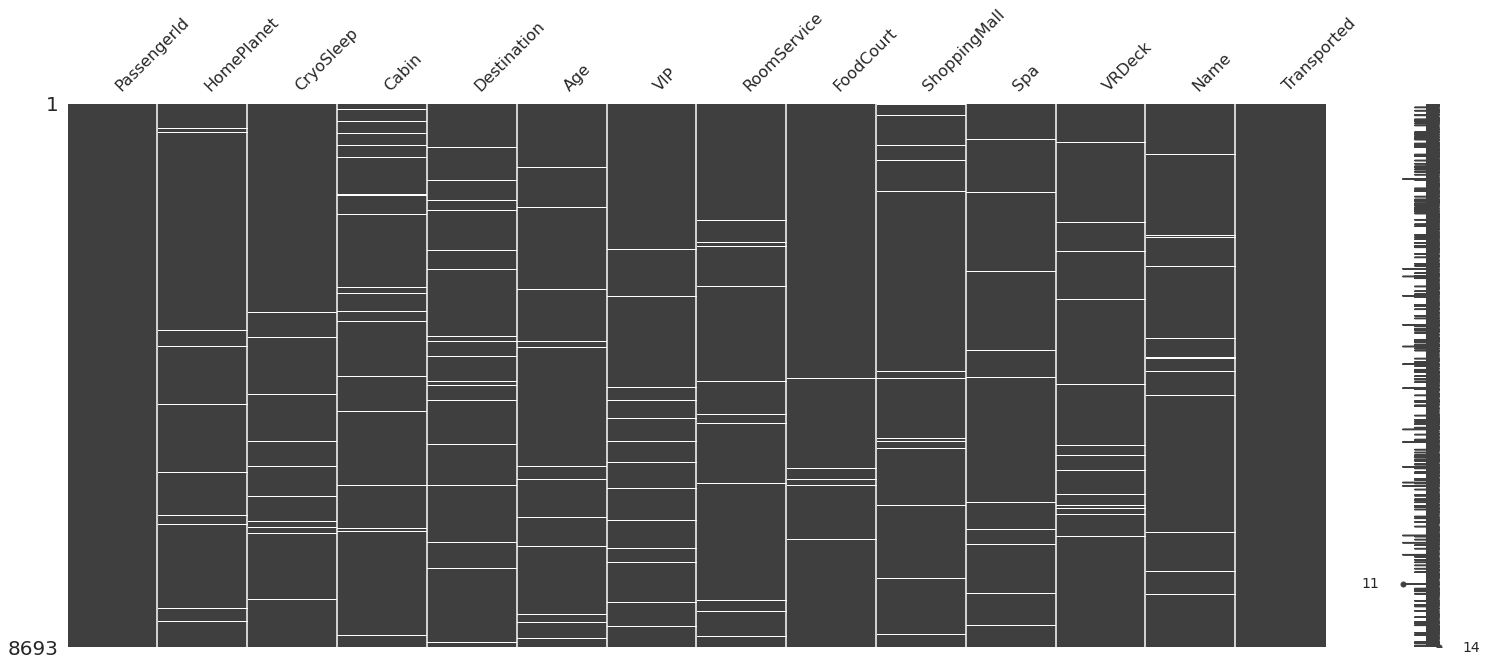

In [17]:
# create a missing values heat map  
msno.matrix(train_df)
plt.show()

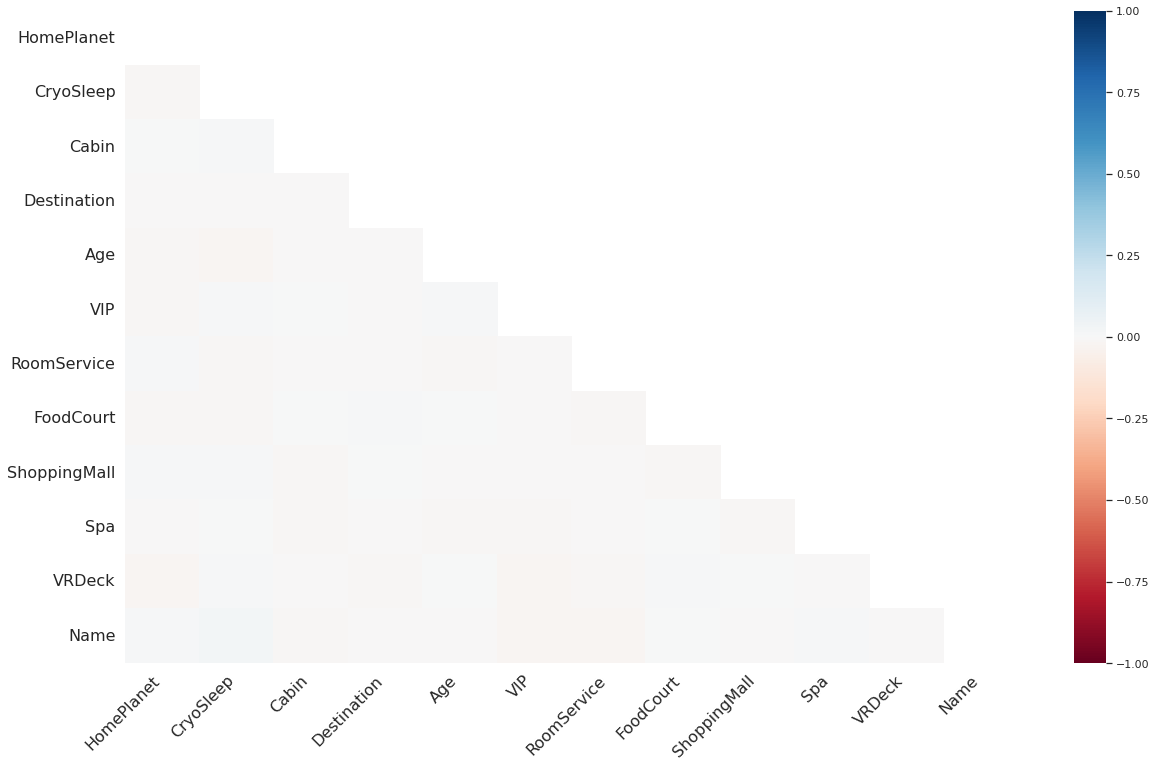

In [18]:
# correlation map of missing features
msno.heatmap(train_df)
plt.show()

## Analysis of Missing Data
* Transported, our target feature, does not have any missing values.
* PassengerId also does not have missing values, so this is a good candidate for an index value if we need one.
* All other features are missing two percent of their observations, which translates to approximately 175 per feature. 
* We know from prior analysis that the test data is missing similar features.
* The visualizations show that there does not appear to be any correlation among the missing features, indicating that they are missing at random. 

# Duplicate Records

In [19]:
print('count of duplicate records:', train_df.duplicated().sum())

count of duplicate records: 0


# Categorical Features

In [20]:
# create list of non-numeric features
categorical_features = train_df.select_dtypes(include=['object', 'bool']).columns
categorical_features

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'Name', 'Transported'],
      dtype='object')

## Transported
*Whether the passenger was transported to another dimension.*

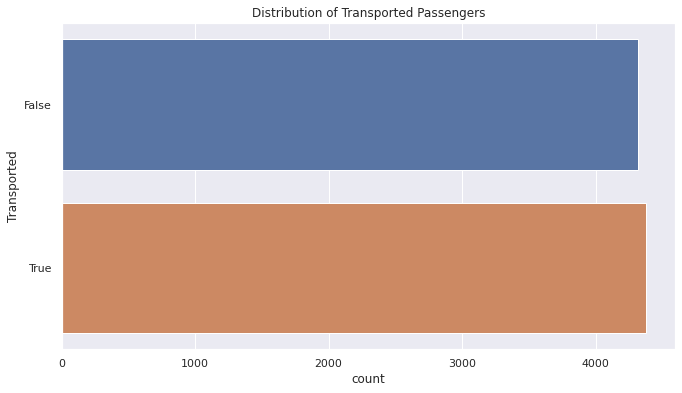

In [15]:
horizontal_countplot(df=train_df, col='Transported', title='Distribution of Transported Passengers')

### Analysis of Transported
* The distribution of transported vs. not transported is about 50/50, as was described in the competition background.
* Because this is our target feature, we may want to evaluate other features in the context versus transported and not transported passengers.

## PassengerId
*A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.*

In [16]:
train_df['PassengerId'].head()

0    0001_01
1    0002_01
2    0003_01
3    0003_02
4    0004_01
Name: PassengerId, dtype: object

### Create Passenger_Group Feature
*We can parse the PassengerGroup feature from the PassengerId feature, which may provide more information about entire groups that were transported. PassengerGroup may also serve as a stand-alone node or passenger property when we create our graph model.*

In [17]:
for df in full_data:
  df['Passenger_Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(str)

In [19]:
print('Count of Unique Passenger Groups:', train_df['Passenger_Group'].nunique())

Count of Unique Passenger Groups: 6217


### Create Group_Size Feature
*Using the Passenger_Group feature, we will count the number of passengers in each group and add that as a feature. In our graph model this may be a property for passengers or groups.*

In [20]:
for df in full_data:
  df['Group_Size'] = df['Passenger_Group'].map(lambda x: pd.concat([train_df['Passenger_Group'], 
                                                                    test_df['Passenger_Group']]).value_counts()[x])

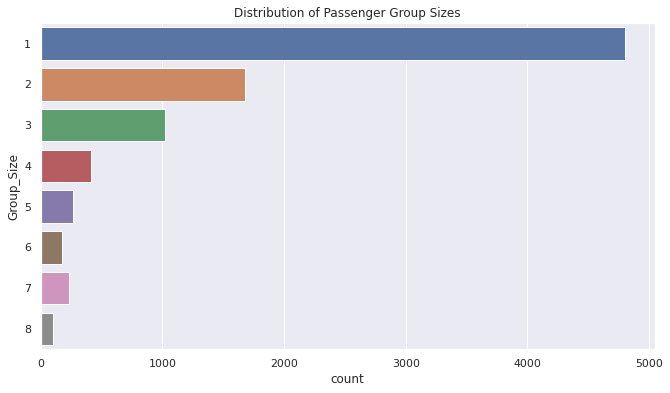

In [21]:
horizontal_countplot(df=train_df, col='Group_Size', 
                     title='Distribution of Passenger Group Sizes')

### Analysis of PassengerId and Related Features
* Each PassengerId is unique, so we can use that as a unique identifier.
* There are approximately 6,200 Passenger Groups:
  * More than half of the passengers are traveling alone
  * Few groups have more than five passengers, with largest comprising eight passengers.

## Passenger Name
*The first and last names of the passenger.*

### Fill Missing Values

In [23]:
for df in full_data:
  df['Name'].fillna('NoFirstName NoSurname', inplace=True)

### Create Surname Feature

In [24]:
train_df['Surname'] = train_df['Name'].str.split(' ').str[-1]

### Analysis of Passenger Surnames

In [25]:
# count of unique surnames
train_df[train_df['Surname'] != 'NoSurname']['Surname'].nunique()

2217

In [26]:
# most common passenger Surnames
train_df[train_df['Surname'] != 'NoSurname']['Surname'].value_counts().head(10)

Casonston     18
Oneiles       16
Domington     15
Litthews      15
Browlerson    14
Garnes        14
Cartez        14
Fulloydez     14
Hinglendez    13
Distured      13
Name: Surname, dtype: int64

In [28]:
# distribution of Surname occurrences
round(train_df[train_df['Surname'] != 'NoSurname']['Surname'].value_counts().describe(),0)

count    2217.0
mean        4.0
std         2.0
min         1.0
25%         2.0
50%         3.0
75%         5.0
max        18.0
Name: Surname, dtype: float64

### Duplicate Passenger Names

In [29]:
# passengers with duplicated name
print('passengers with duplicated name:', len({x: count for x, count in Counter(train_df['Name']).items() if count == 2}))

passengers with duplicated name: 20


In [30]:
# first five passengers with duplicated names
(
    train_df[train_df.duplicated(['Name'], keep=False)]
    .dropna(subset=['Name'])
    .sort_values(by='Name')
    .head(10)
)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Passenger_Group,Group_Size,Surname
6296,6665_01,Europa,True,B/222/P,55 Cancri e,17.0,False,0.0,0.0,0.0,0.0,0.0,Alraium Disivering,True,6665,4,Disivering
7270,7775_01,Europa,False,C/253/P,55 Cancri e,28.0,False,7.0,489.0,0.0,4.0,6027.0,Alraium Disivering,False,7775,1,Disivering
2930,3176_01,Europa,False,E/196/P,TRAPPIST-1e,77.0,False,0.0,9032.0,0.0,128.0,1464.0,Ankalik Nateansive,True,3176,1,Nateansive
476,0512_02,Europa,True,D/18/S,TRAPPIST-1e,55.0,False,0.0,0.0,0.0,0.0,0.0,Ankalik Nateansive,True,0512,2,Nateansive
8488,9071_01,Earth,False,F/1855/P,55 Cancri e,22.0,False,0.0,0.0,1072.0,46.0,3.0,Anton Woody,False,9071,1,Woody
2991,3236_03,Earth,False,E/200/P,TRAPPIST-1e,18.0,False,0.0,30.0,0.0,756.0,5.0,Anton Woody,False,3236,3,Woody
4108,4387_01,Mars,False,F/902/P,PSO J318.5-22,32.0,False,192.0,0.0,441.0,18.0,0.0,Apix Wala,False,4387,1,Wala
2559,2746_01,Mars,False,F/569/P,TRAPPIST-1e,52.0,False,758.0,0.0,356.0,5.0,0.0,Apix Wala,False,2746,1,Wala
7871,8398_01,Europa,True,B/329/S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,0.0,Asch Stradick,True,8398,2,Stradick
6086,6432_01,Europa,False,D/202/P,55 Cancri e,55.0,False,114.0,222.0,0.0,2575.0,2919.0,Asch Stradick,False,6432,1,Stradick


* Twenty passengers in the training data have duplicate names.
* Analysis of additional features show that passengers with duplicate names have other, meaningful differences indicating that they appear to be different people who happen to share a name. 
* It does not appear that Passenger Name will be useful as an analytic feature or unique identifier. 

## Cabin
*The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.*

In [32]:
train_df['Cabin'].value_counts().head()

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
Name: Cabin, dtype: int64

### Fill Missing Values 
Before parsing the Passenger Cabin feature into deck, number, and side, we need to fill in missing values. The function to implement this is provided at the top of this notebook.
* For passengers traveling alone, we will impute an arbitrary value of 'F/999/P' based on prior analysis that showed F is the most common deck and had similar characteristics to passengers with missing Cabins. This was also the case with passengers on the 'Port' side of the ship, so we filled P as well.
* For passengers traveling in groups of two or more we will use forward-fill or backward-fill to use the cabin of another passenger in the same group.
* For any outlier instances where all travelers in a group are missing a cabin we will fill using the 'F/999/P' cabin.

In [33]:
train_df = fill_categorical(df=train_df, col='Cabin', 
                            fill_value = 'F/999/P')

In [34]:
test_df = fill_categorical(df=test_df, col='Cabin', 
                            fill_value = 'F/999/P')

In [35]:
print('count of unique cabins:', train_df['Cabin'].nunique())

count of unique cabins: 6560


### Parse Cabin into Deck, Number, and Side

In [36]:
for df in full_data:
  df['Cabin_Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0]).astype(str)
  df['Cabin_Num'] = df['Cabin'].apply(lambda x: x.split('/')[1]).astype(str)
  df['Cabin_Side'] = df['Cabin'].apply(lambda x: x.split('/')[2]).astype(str) 

In [37]:
train_df['Cabin_Deck'] = train_df['Cabin_Deck'].astype('category')
test_df['Cabin_Deck'] = test_df['Cabin_Deck'].astype('category')

train_df['Cabin_Side'] = train_df['Cabin_Side'].astype('category')
test_df['Cabin_Side'] = test_df['Cabin_Side'].astype('category')

In [38]:
# remove slashes from original cabin value 
train_df['Cabin'] = train_df['Cabin'].str.replace('/', '')

### Passenger Cabin Deck

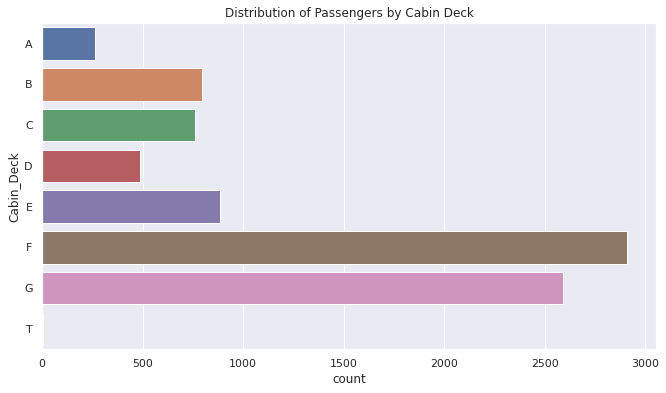

In [39]:
horizontal_countplot(df=train_df, 
                     col='Cabin_Deck', 
                     title = 'Distribution of Passengers by Cabin Deck',
                     order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])

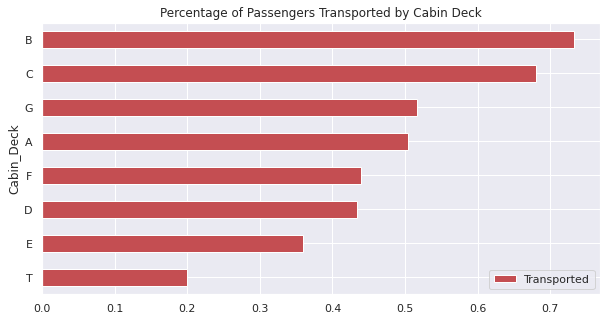

In [40]:
plot_transported_pct(df=train_df, 
                     col='Cabin_Deck', 
                     title='Percentage of Passengers Transported by Cabin Deck')

### Passenger Cabin Side

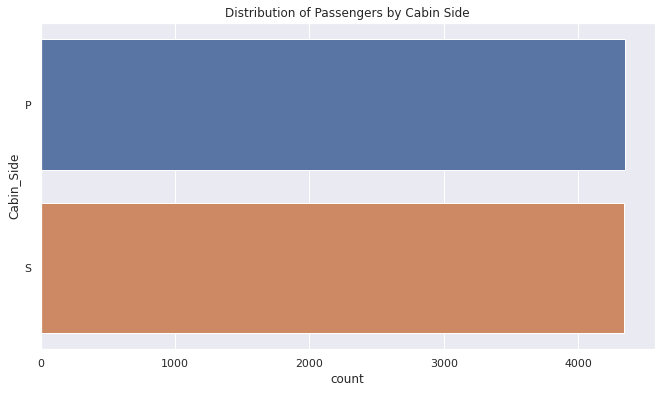

In [41]:
horizontal_countplot(df=train_df, col='Cabin_Side',
                     title='Distribution of Passengers by Cabin Side')

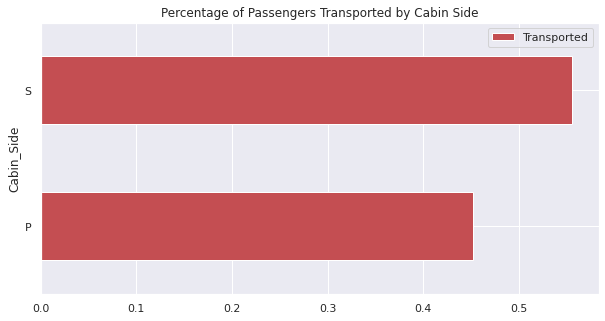

In [42]:
plot_transported_pct(df=train_df, col='Cabin_Side', 
                     title='Percentage of Passengers Transported by Cabin Side')

### Analysis of Passenger Cabin
* `Cabin_Deck:` Passengers on decks B and C appear to have a dramatically higher chance of being transported, while passengers on decks E and the sparsely populated T have much lower changes of being transported.
* `Cabin_Side:` While the distribution of passengers is relatively even, as expected, it appears passengers on the Starboard side have a slightly higher rate of being transported than do passengers on the Port side. 

## Home Planet
*The planet the passenger departed from, typically their planet of permanent residence.*

### Impute Missing Values
Impute using the mode for the train and test data sets respectively.

In [43]:
train_df = fill_categorical(df=train_df, col='HomePlanet', 
                            fill_value=train_df['HomePlanet'].value_counts().index[0])

train_df['HomePlanet'] = train_df['HomePlanet'].astype('category')

In [44]:
test_df = fill_categorical(df=test_df, col='HomePlanet', 
                           fill_value=test_df['HomePlanet'].value_counts().index[0])

test_df['HomePlanet'] = test_df['HomePlanet'].astype('category')

### Analysis of HomePlanet

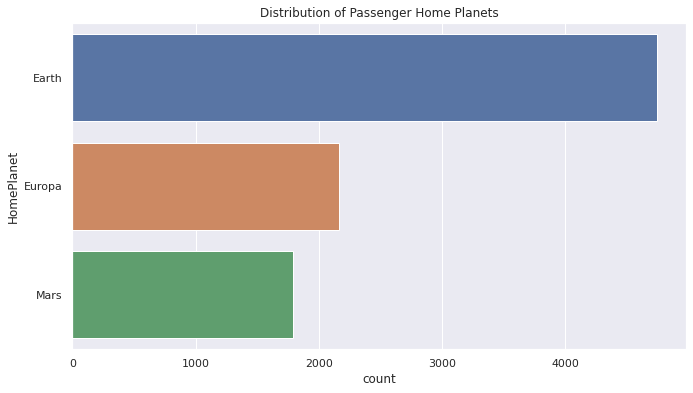

In [45]:
horizontal_countplot(df=train_df, col='HomePlanet', 
                     title='Distribution of Passenger Home Planets',
                     order=['Earth', 'Europa', 'Mars'])

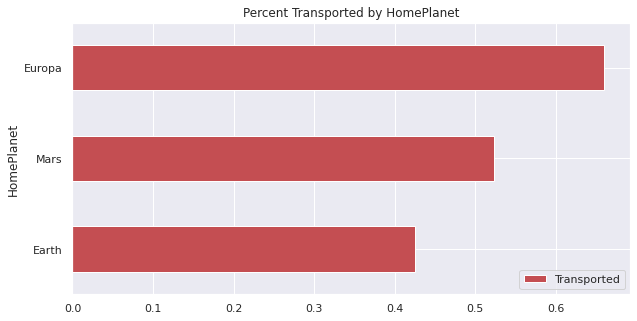

In [46]:
plot_transported_pct(df=train_df, col='HomePlanet', 
                     title='Percent Transported by HomePlanet')

* Earth is the most frequent HomePlanet for passengers.
* Passengers from Europa have an almost 15% higher chance of being transported vs. passengers from Earth having about an 8% lower chance of being transported.

## Destination
*The planet the passenger will be debarking to.*

### Remove Non-Alphanumeric Characters
The non-alphanumeric characters are not necessary and could interfere with other analysis.

In [47]:
for df in full_data:
  df['Destination'] = df['Destination'].str.replace('[^a-zA-Z0-9]', '', regex=True).str.strip()

### Impute Missing Values
Fill based upon the most frequent value in the data.

In [48]:
train_df = fill_categorical(df=train_df, col='Destination', 
                            fill_value=train_df['Destination'].value_counts().index[0])

train_df['Destination'] = train_df['Destination'].astype('category')

In [49]:
test_df = fill_categorical(df=test_df, col='Destination', 
                           fill_value=test_df['Destination'].value_counts().index[0])

test_df['Destination'] = test_df['Destination'].astype('category')

### Analysis of Destination

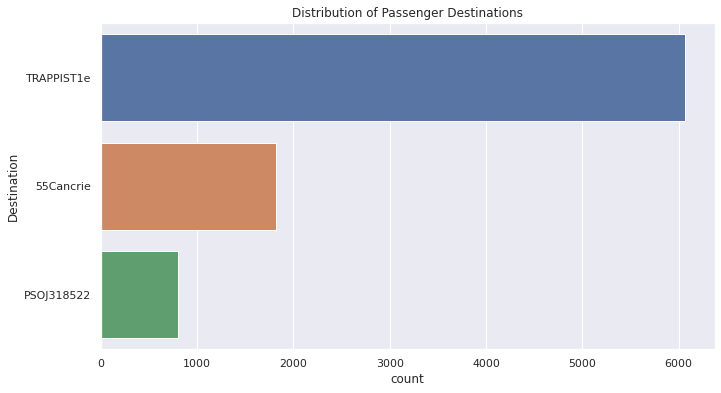

In [50]:
horizontal_countplot(df=train_df, col='Destination',
                     title='Distribution of Passenger Destinations',
                     order=['TRAPPIST1e', '55Cancrie', 'PSOJ318522'])

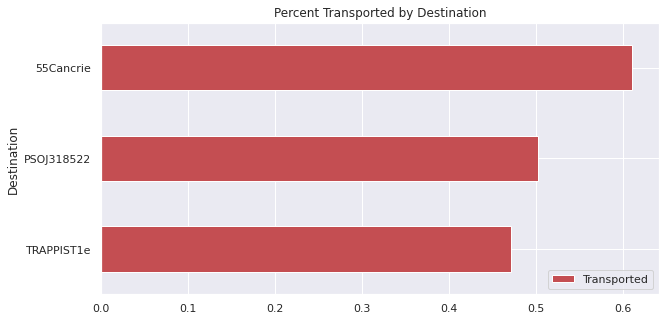

In [51]:
plot_transported_pct(df=train_df, col='Destination', 
                     title='Percent Transported by Destination')

* Trappist-1e is by far the most common passenger destination.
* Passengers traveling to 55 Cancri e have more than a 60% chance of being transported, while passengers traveling to Trappist-1e have a slightly less than 50% chance of being transported. 

## CryoSleep
*Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.*

### Impute Missing Values
Fill based on the most frequent value. 

In [52]:
train_df = fill_categorical(df=train_df, col='CryoSleep', 
                            fill_value=train_df['CryoSleep'].value_counts().index[0])
train_df['CryoSleep'] = train_df['CryoSleep'].astype('category')


In [53]:
test_df = fill_categorical(df=test_df, col='CryoSleep', 
                           fill_value=test_df['CryoSleep'].value_counts().index[0])
test_df['CryoSleep'] = test_df['CryoSleep'].astype('category')

### Analysis of CryoSleep

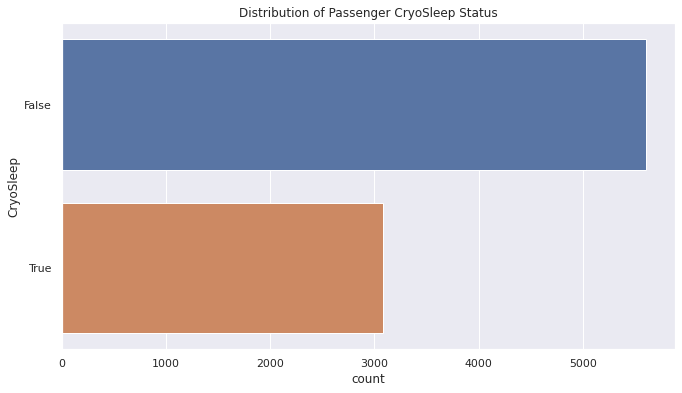

In [54]:
horizontal_countplot(df=train_df, col='CryoSleep',
                     title='Distribution of Passenger CryoSleep Status')

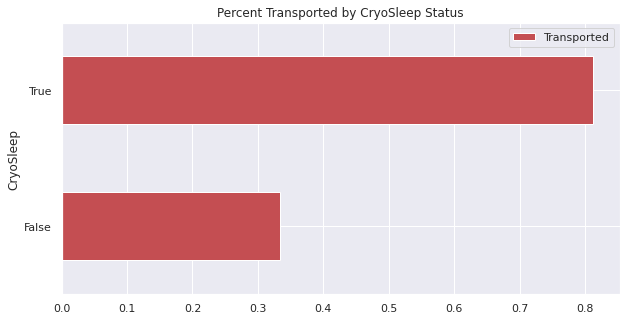

In [55]:
plot_transported_pct(df=train_df, col='CryoSleep', 
                     title='Percent Transported by CryoSleep Status')

* Approximately one-third of passengers chose to be put into CryoSleep during the voyage.
* Those that were placed into CryoSleep appear to have a better than 80% chance of being transported to another dimension, making this likely one of our most important predictor variables.

## VIP Status
*Whether the passenger has paid for special VIP service during the voyage.*

### Impute Missing Values
Fill based on the most frequent value.

In [56]:
train_df = fill_categorical(df=train_df, col='VIP', 
                            fill_value=train_df['VIP'].value_counts().index[0])
train_df['VIP'] = train_df['VIP'].astype('category')

In [57]:
test_df = fill_categorical(df=test_df, col='VIP', 
                           fill_value=test_df['VIP'].value_counts().index[0])
test_df['VIP'] = test_df['VIP'].astype('category')

### Analysis of VIP Status

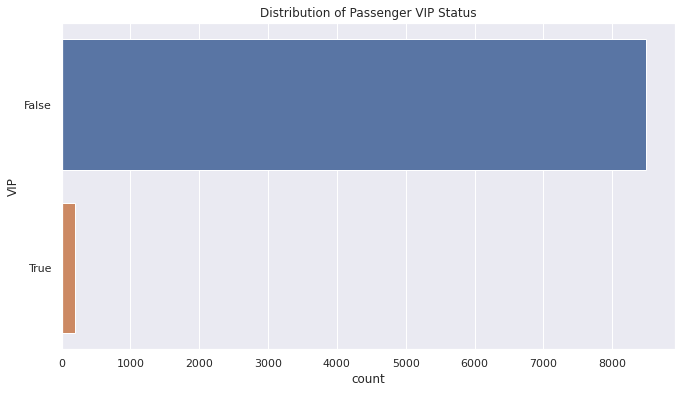

In [58]:
horizontal_countplot(df=train_df, col='VIP',
                     title='Distribution of Passenger VIP Status')

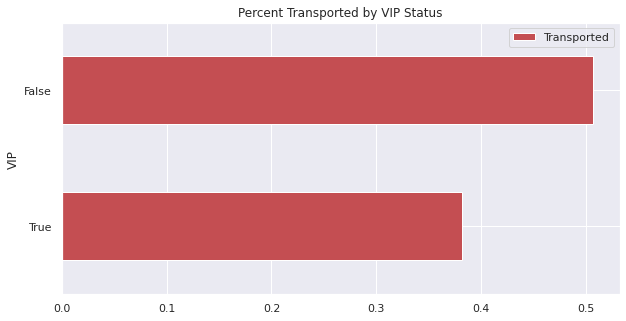

In [59]:
plot_transported_pct(df=train_df, col='VIP', title='Percent Transported by VIP Status')

* Few passengers have VIP status on the ship.
* Those who do have about a 12% lower chance of being transported than do non-VIP passengers.

# Numeric Features

## Impute Missing Numeric Values
  * `Age:` The mean and median are very close, so we will impute the median to be consistent.
  * `Onboard Spend Categories:` The median value for all five of these categories is zero, indicating a heavy skew. Therefore we will also use the median. 

In [60]:
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for df in full_data:
  for feature in numeric_features:
    df[feature].fillna(df[feature].median(), inplace=True)

In [61]:
for df in full_data:
  for feature in numeric_features:
    df[feature] = df[feature].astype(int)

In [62]:
round(train_df[numeric_features].describe(), 0).T

,count,mean,std,min,25%,50%,75%,max
Age,8693.0,29.0,14.0,0.0,20.0,27.0,37.0,79.0
RoomService,8693.0,220.0,661.0,0.0,0.0,0.0,41.0,14327.0
FoodCourt,8693.0,448.0,1596.0,0.0,0.0,0.0,61.0,29813.0
ShoppingMall,8693.0,170.0,598.0,0.0,0.0,0.0,22.0,23492.0
Spa,8693.0,305.0,1126.0,0.0,0.0,0.0,53.0,22408.0
VRDeck,8693.0,298.0,1134.0,0.0,0.0,0.0,40.0,24133.0


## Age
*Age of the passenger.*

In [63]:
create_desc_df(df=train_df, col='Age')

,All,Transported,Not Transported
count,8693.0,4378.0,4315.0
mean,29.0,28.0,30.0
std,14.0,15.0,14.0
min,0.0,0.0,0.0
25%,20.0,18.0,21.0
50%,27.0,27.0,27.0
75%,37.0,37.0,38.0
max,79.0,78.0,79.0


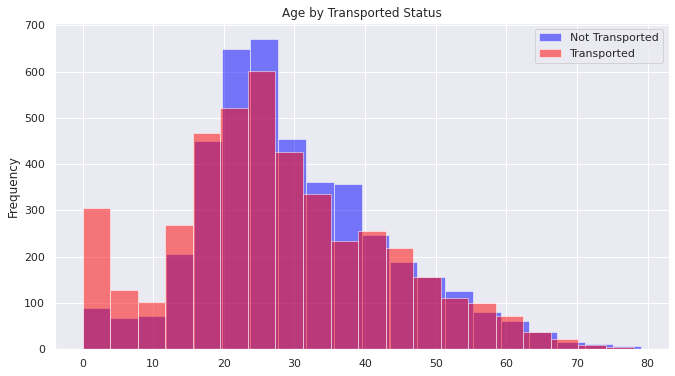

In [64]:
plot_transported_hist(df=train_df, col='Age')

### Analysis of Age
* Passengers under 20 years old appear to have a higher rate of being transported.
* Passengers with ages approx 20 - 40 appear to have a lower probability of being transported.
* From age 40 on the percentages appear roughly even between Transported and Not.

## Onboard Spend Categories
Amounts spent by the passenger on `RoomService`, or at the `FoodCourt`, `ShoppingMall`, `Spa`, and `VRDeck`.

### Create Total Spend Feature
We will add up all passenger spending to create a total which can then help with analysis and filtering.

In [65]:
# create Total_Spend feature 
for df in full_data:
    df['Total_Spend'] = (  df['RoomService'] 
                         + df['FoodCourt'] 
                         + df['ShoppingMall']
                         + df['Spa'] 
                         + df['VRDeck']  )
    
    df['Total_Spend'] = df['Total_Spend'].astype(int)

### Analysis of Total_Spend

In [66]:
create_desc_df(df=train_df, col='Total_Spend')

,All,Transported,Not Transported
count,8693.0,4378.0,4315.0
mean,1441.0,886.0,2004.0
std,2803.0,2298.0,3137.0
min,0.0,0.0,0.0
25%,0.0,0.0,678.0
50%,716.0,0.0,907.0
75%,1441.0,809.0,2093.0
max,35987.0,31076.0,35987.0


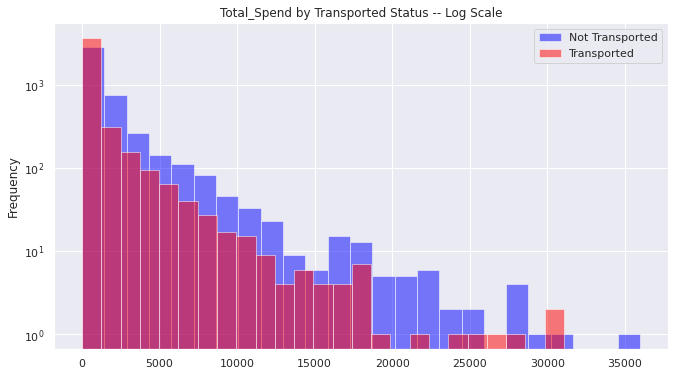

In [67]:
plot_transported_hist(df=train_df, col='Total_Spend', bins=25, log=True)

* Passengers with zero (or minimal) spend appear to be transported at a higher rate than passengers who spent money onboard.
* However, this feature may be correlated with passengers in CryoSleep status (and therefore who did not spend), who also had a much higher rate of being transported than the rest of the passengers. 

### RoomService

In [68]:
create_desc_df(df=train_df, col='RoomService')

,All,Transported,Not Transported
count,8693.0,4378.0,4315.0
mean,220.0,62.0,380.0
std,661.0,272.0,868.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,1.0
75%,41.0,0.0,454.0
max,14327.0,3992.0,14327.0


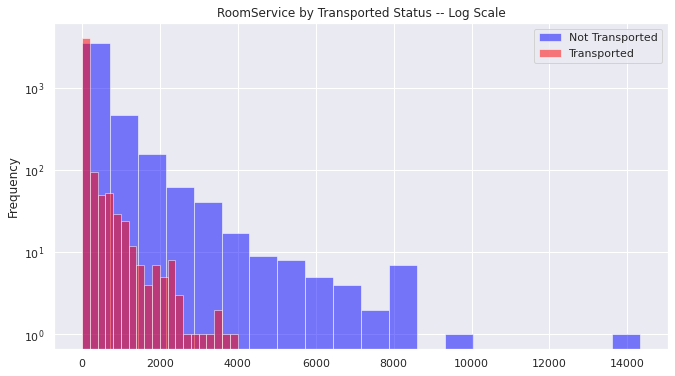

In [69]:
plot_transported_hist(df=train_df, col='RoomService', log=True)

### FoodCourt 

In [70]:
create_desc_df(df=train_df, col='FoodCourt')

,All,Transported,Not Transported
count,8693.0,4378.0,4315.0
mean,448.0,521.0,375.0
std,1596.0,1911.0,1190.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,61.0,0.0,168.0
max,29813.0,29813.0,16856.0


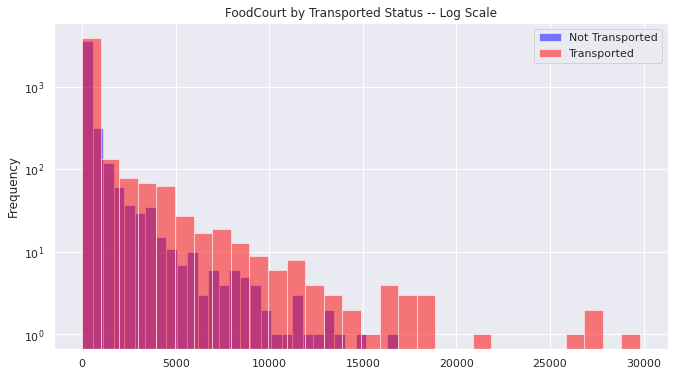

In [71]:
plot_transported_hist(df=train_df, col='FoodCourt', bins=30, log=True)

### ShoppingMall

In [72]:
create_desc_df(df=train_df, col='ShoppingMall')

,All,Transported,Not Transported
count,8693.0,4378.0,4315.0
mean,170.0,175.0,164.0
std,598.0,713.0,452.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,22.0,0.0,87.0
max,23492.0,23492.0,10705.0


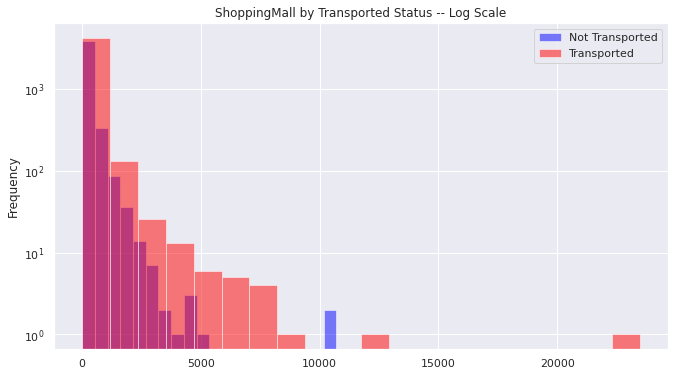

In [73]:
plot_transported_hist(df=train_df, col='ShoppingMall', log=True)

### Spa

In [74]:
create_desc_df(df=train_df, col='Spa')

,All,Transported,Not Transported
count,8693.0,4378.0,4315.0
mean,305.0,60.0,552.0
std,1126.0,260.0,1537.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,2.0
75%,53.0,0.0,431.0
max,22408.0,4103.0,22408.0


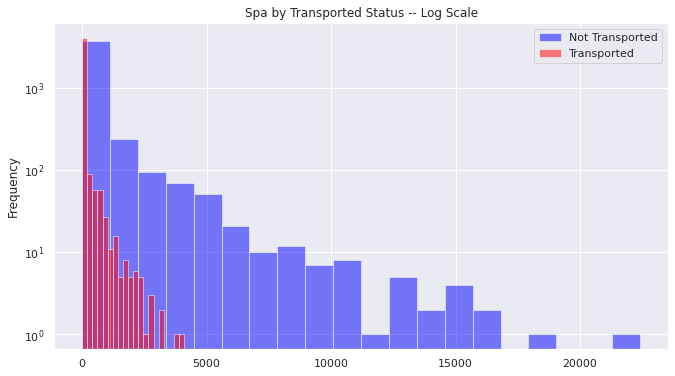

In [75]:
plot_transported_hist(df=train_df, col='Spa', log=True)

### VRDeck

In [76]:
create_desc_df(df=train_df, col='VRDeck')

,All,Transported,Not Transported
count,8693.0,4378.0,4315.0
mean,298.0,68.0,532.0
std,1134.0,289.0,1549.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,1.0
75%,40.0,0.0,372.0
max,24133.0,5063.0,24133.0


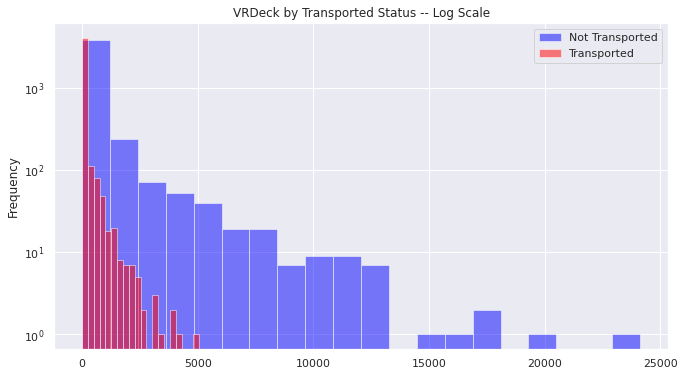

In [77]:
plot_transported_hist(df=train_df, col='VRDeck', log=True)

# Identify Inconsistencies and Outliers
*Review prepared and formatted features to confirm imputation and look for any apparent inconsistencies. Also attempt to identify additional relationships that may factor into the graph data model or analysis.*

## CryoSleep and Onboard Spending
*Confirm that passengers in CryoSleep do not have any onboard spending.*

In [78]:
# identify passengers with onboard spend and who are in cryosleep
train_df[(train_df['CryoSleep'] == True) & (train_df['Total_Spend'] > 0)].shape

(25, 21)

In [79]:
# set CryoSleep to false for passengers who have onboard spend 
train_df.loc[(train_df['CryoSleep'] == True) & (train_df['Total_Spend'] > 0), 'CryoSleep'] = False

In [80]:
# confirm now zero 
train_df[(train_df['CryoSleep'] == True) & (train_df['Total_Spend'] > 0)].shape

(0, 21)

## HomePlanet and Cabin Deck

In [81]:
pd.crosstab(index = train_df['HomePlanet'], 
            columns = train_df['Cabin_Deck'], 
            values = train_df['PassengerId'],
            aggfunc='nunique')

Cabin_Deck,A,B,C,D,E,F,G,T
HomePlanet,,,,,,,,
Earth,1,1,4,4,414,1731,2589,1
Europa,261,795,757,192,131,21,0,4
Mars,0,0,0,291,341,1155,0,0


In [82]:
# adjust for potential inconsistencies due to imputation 
train_df.loc[(train_df['HomePlanet'] == 'Earth') & 
             (train_df['Cabin_Deck'].str.contains('A|B|C|D|T')),
             'HomePlanet'] = 'Europa'

In [83]:
pd.crosstab(index = train_df['HomePlanet'], 
            columns = train_df['Cabin_Deck'], 
            values = train_df['PassengerId'],
            aggfunc='nunique')

Cabin_Deck,A,B,C,D,E,F,G,T
HomePlanet,,,,,,,,
Earth,0,0,0,0,414,1731,2589,0
Europa,262,796,761,196,131,21,0,5
Mars,0,0,0,291,341,1155,0,0


## Passenger Groups and Cabin Side
*Passengers in the same group all appear to travel on the same side of the ship.*

In [84]:
# all passengers in a group travel on the same side
(
    train_df[['Cabin_Side', 'Passenger_Group']]
    .groupby('Passenger_Group')
    .agg('nunique')
    .sort_values(by='Cabin_Side', ascending=False) > 1
).sum()

Cabin_Side    0
dtype: int64

# Prepare Data For Modeling

In [85]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PassengerId      8693 non-null   object  
 1   HomePlanet       8693 non-null   category
 2   CryoSleep        8693 non-null   category
 3   Cabin            8693 non-null   object  
 4   Destination      8693 non-null   category
 5   Age              8693 non-null   int64   
 6   VIP              8693 non-null   category
 7   RoomService      8693 non-null   int64   
 8   FoodCourt        8693 non-null   int64   
 9   ShoppingMall     8693 non-null   int64   
 10  Spa              8693 non-null   int64   
 11  VRDeck           8693 non-null   int64   
 12  Name             8693 non-null   object  
 13  Transported      8693 non-null   bool    
 14  Passenger_Group  8693 non-null   object  
 15  Group_Size       8693 non-null   int64   
 16  Surname          8693 non-null   object  


In [86]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Passenger_Group,Group_Size,Surname,Cabin_Deck,Cabin_Num,Cabin_Side,Total_Spend
0,0001_01,Europa,False,B0P,TRAPPIST1e,39,False,0,0,0,0,0,Maham Ofracculy,False,0001,1,Ofracculy,B,0,P,0
1,0002_01,Earth,False,F0S,TRAPPIST1e,24,False,109,9,25,549,44,Juanna Vines,True,0002,1,Vines,F,0,S,736
2,0003_01,Europa,False,A0S,TRAPPIST1e,58,True,43,3576,0,6715,49,Altark Susent,False,0003,2,Susent,A,0,S,10383
3,0003_02,Europa,False,A0S,TRAPPIST1e,33,False,0,1283,371,3329,193,Solam Susent,False,0003,2,Susent,A,0,S,5176
4,0004_01,Earth,False,F1S,TRAPPIST1e,16,False,303,70,151,565,2,Willy Santantines,True,0004,1,Santantines,F,1,S,1091


## One-Hot Encoding Categorical Features

In [87]:
cat_features = train_df.select_dtypes(include='category').columns.tolist()
cat_features

['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Side']

In [88]:
train_cat_processed = pd.get_dummies(train_df[cat_features], drop_first=True)
train_cat_processed.shape

(8693, 14)

In [89]:
train_cat_processed.head()

,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,Destination_PSOJ318522,Destination_TRAPPIST1e,VIP_True,Cabin_Deck_B,Cabin_Deck_C,Cabin_Deck_D,Cabin_Deck_E,Cabin_Deck_F,Cabin_Deck_G,Cabin_Deck_T,Cabin_Side_S
0,1,0,0,0,1,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,1,0,0,1
2,1,0,0,0,1,1,0,0,0,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,1,0,0,1


## Select Quant Features

In [90]:
quant_features = train_df.select_dtypes(include='int').columns.tolist()
quant_features

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Group_Size',
 'Total_Spend']

## Training Data Sets

In [91]:
# combine training features
X_train = pd.concat([train_cat_processed, train_df[quant_features]], axis=1)
X_train.shape

(8693, 22)

In [92]:
y = train_df['Transported']
y.shape

(8693,)

# Baseline Random Forest Model
*Based on prior analyisis these features get us just over 80% accuracy on the training data.*

## Model

In [93]:
# specify the model with optimal parameters
rf_model = RandomForestClassifier(criterion='entropy', 
                                  n_estimators=450,
                                  min_samples_split=32,
                                  min_samples_leaf=3,
                                  max_features='sqrt',
                                  oob_score=True,
                                  max_depth=45,
                                  random_state=1,
                                  n_jobs=-1)

In [94]:
# fit to training data 
rf_model.fit(X_train, y)


RandomForestClassifier(criterion='entropy', max_depth=45, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=32,
                       n_estimators=450, n_jobs=-1, oob_score=True,
                       random_state=1)

## Feature Importance

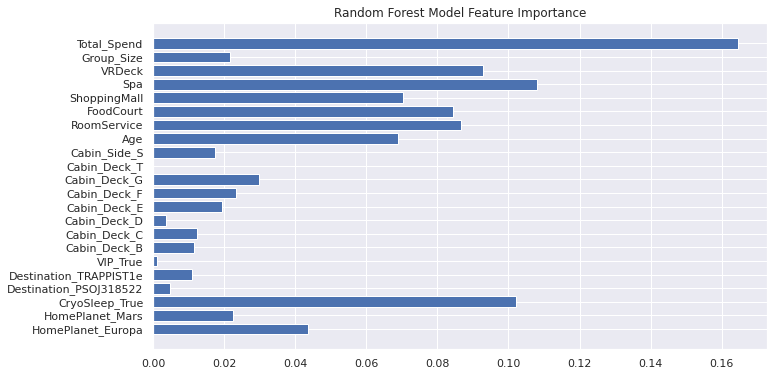

In [95]:
plt.barh(X_train.columns, rf_model.feature_importances_)
plt.title('Random Forest Model Feature Importance')
plt.show()

# Output Processed Training Data
Write processed data to CSV for further preprocessing into node and edge lists.

In [96]:
train_df.to_csv('source_data/spaceshipTitanic_train_processed.csv', index=None)